In [1]:

import importlib
from load_package_gpu import *


1 Physical GPUs, 1 Logical GPUs
tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf


Using TensorFlow backend.


In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
y_train_valid -= 769
y_test -= 769
perm = np.random.permutation(X_train_valid.shape[0])
numTrain = int(0.8*X_train_valid.shape[0])
numVal = X_train_valid.shape[0] - numTrain
Xtrain = X_train_valid[perm[0:numTrain]]
ytrain = y_train_valid[perm[0:numTrain]]
Xval = X_train_valid[perm[numTrain: ]]
yval = y_train_valid[perm[numTrain: ]]

In [3]:
from keras import backend as K
def Ksquare(x):
    return K.pow(x, 2)
def Klog(x):
    return K.log(x)

In [4]:
inputs = layers.Input(shape=(22, 1000))
r1 = layers.Reshape((1, 22, 1000))(inputs)
c1 = layers.Conv2D(40, (1, 25), strides=1, activation='elu',
                  data_format='channels_first')(r1)
r2 = layers.Reshape((1, 40*22, 976))(c1)
c2 = layers.Conv2D(40, (40*22, 1), strides=1, activation='elu',
                  data_format='channels_first')(r2)
sq1 = layers.Activation(Ksquare)(c2)
r3 = layers.Reshape((1, 40, 976))(sq1)
apool1 = layers.AveragePooling2D((1, 75), strides=(1, 15), 
                                 data_format = 'channels_first')(r3)
log1 = layers.Activation(Klog)(apool1)
f1 = layers.Flatten()(log1)
outputs = layers.Dense(4, activation='softmax')(f1)

In [5]:
model = models.Model(inputs = inputs, outputs = outputs)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 22, 1000)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 22, 1000)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 22, 976)       1040      
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 880, 976)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 1, 976)        35240     
_________________________________________________________________
activation_1 (Activation)    (None, 40, 1, 976)        0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 40, 976)        0   

In [6]:
loss_hist = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                     epochs = 10)

Train on 1692 samples, validate on 423 samples
Epoch 1/10
1692/1692 [==============================] - 2s 1ms/step - loss: 2.0033 - acc: 0.3067 - val_loss: 1.3809 - val_acc: 0.3121
Epoch 2/10
1692/1692 [==============================] - 1s 615us/step - loss: 1.3223 - acc: 0.3794 - val_loss: 1.3641 - val_acc: 0.3262
Epoch 3/10
1692/1692 [==============================] - 1s 687us/step - loss: 1.2287 - acc: 0.4569 - val_loss: 1.3038 - val_acc: 0.3972
Epoch 4/10
1692/1692 [==============================] - 1s 690us/step - loss: 1.1194 - acc: 0.5148 - val_loss: 1.2689 - val_acc: 0.4066
Epoch 5/10
1692/1692 [==============================] - 1s 685us/step - loss: 1.0535 - acc: 0.5514 - val_loss: 1.2308 - val_acc: 0.4208
Epoch 6/10
1692/1692 [==============================] - 1s 531us/step - loss: 0.9590 - acc: 0.6129 - val_loss: 1.1643 - val_acc: 0.5130
Epoch 7/10
1692/1692 [==============================] - 1s 647us/step - loss: 0.8662 - acc: 0.6560 - val_loss: 1.1809 - val_acc: 0.5154
Epo

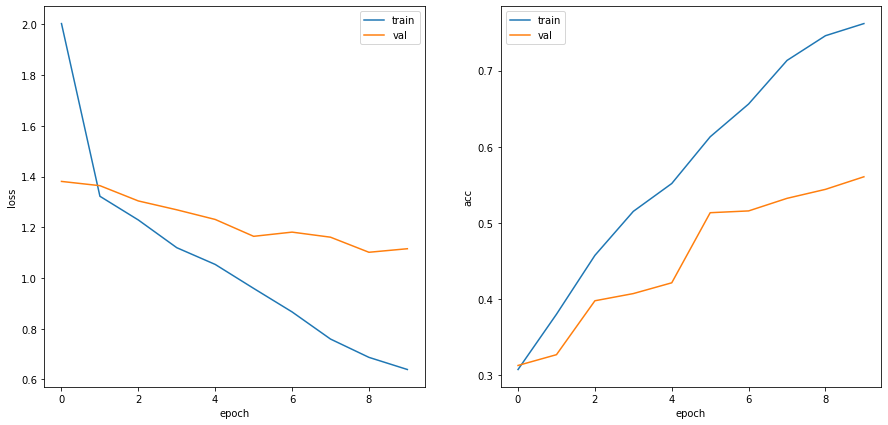

In [7]:
hist = loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

## Now we try to build a NN with LSTM + (CNN+pool)*2 + softmax

Some assumptions: 
1. EEG can be view as force inputs to a system, we need to integrate the result force, RNN can be view as a weighted moving average filter
1. Different 

In [58]:
hidden_size = 20
inputs = layers.Input(shape=(22, 1000))
p1 = layers.Permute((2,1))(inputs)
r1 = layers.LSTM(units = hidden_size,return_sequences=True)(p1)
p2 = layers.Permute((2,1))(r1)
c1 = layers.Conv1D(filters=10,kernel_size=10)(p2)
pool1 = layers.MaxPool1D(pool_size=2)(c1)
c2 = layers.Conv1D(filters=20,kernel_size=2)(pool1)
pool2 = layers.MaxPool1D(pool_size=2)(c2)
f1 = layers.Flatten()(pool2)
outputs = layers.Dense(4, activation='softmax')(f1)

In [59]:
model = models.Model(inputs = inputs, outputs = outputs)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

In [60]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 22, 1000)          0         
_________________________________________________________________
permute_42 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 1000, 20)          3440      
_________________________________________________________________
permute_43 (Permute)         (None, 20, 1000)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 11, 10)            100010    
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 5, 10)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 4, 20)             420 

In [61]:
loss_hist = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                     epochs = 4)

Train on 1692 samples, validate on 423 samples
Epoch 1/4
1692/1692 [==============================] - 19s 11ms/step - loss: 1.4579 - acc: 0.3132 - val_loss: 1.3680 - val_acc: 0.3877
Epoch 2/4
1692/1692 [==============================] - 19s 11ms/step - loss: 0.6413 - acc: 0.8126 - val_loss: 1.4940 - val_acc: 0.3641
Epoch 3/4
1692/1692 [==============================] - 19s 11ms/step - loss: 0.2417 - acc: 0.9693 - val_loss: 1.5735 - val_acc: 0.3806
Epoch 4/4
1692/1692 [==============================] - 19s 11ms/step - loss: 0.0729 - acc: 0.9994 - val_loss: 1.7323 - val_acc: 0.3948


## We overfit it apparently

In [62]:
hidden_size = 50
inputs = layers.Input(shape=(22, 1000))
p1 = layers.Permute((2,1))(inputs)
r1 = layers.LSTM(units = hidden_size,return_sequences=True)(p1)
p2 = layers.Permute((2,1))(r1)
c1 = layers.Conv1D(filters=10,kernel_size=10)(p2)
pool1 = layers.MaxPool1D(pool_size=2)(c1)
c2 = layers.Conv1D(filters=20,kernel_size=2)(pool1)
pool2 = layers.MaxPool1D(pool_size=2)(c2)
f1 = layers.Flatten()(pool2)
outputs = layers.Dense(4, activation='softmax')(f1)
model = models.Model(inputs = inputs, outputs = outputs)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

loss_hist = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                     epochs = 4)

Train on 1692 samples, validate on 423 samples
Epoch 1/4
1692/1692 [==============================] - 20s 12ms/step - loss: 1.4257 - acc: 0.3316 - val_loss: 1.3190 - val_acc: 0.3995
Epoch 2/4
1692/1692 [==============================] - 20s 12ms/step - loss: 0.7193 - acc: 0.7500 - val_loss: 1.4100 - val_acc: 0.3877
Epoch 3/4
1692/1692 [==============================] - 20s 12ms/step - loss: 0.2998 - acc: 0.9527 - val_loss: 1.5453 - val_acc: 0.4019
Epoch 4/4
1692/1692 [==============================] - 19s 12ms/step - loss: 0.0976 - acc: 0.9982 - val_loss: 1.5748 - val_acc: 0.4113


In [63]:
hidden_size = 50
inputs = layers.Input(shape=(22, 1000))
p1 = layers.Permute((2,1))(inputs)
r1 = layers.LSTM(units = hidden_size,return_sequences=True)(p1)
p2 = layers.Permute((2,1))(r1)
c1 = layers.Conv1D(filters=10,kernel_size=3)(p2)
pool1 = layers.MaxPool1D(pool_size=2)(c1)
c2 = layers.Conv1D(filters=20,kernel_size=3)(pool1)
pool2 = layers.MaxPool1D(pool_size=2)(c2)
c3 = layers.Conv1D(filters=20,kernel_size=3)(pool2)
pool3 = layers.MaxPool1D(pool_size=2)(c3)


f1 = layers.Flatten()(pool3)
outputs = layers.Dense(4, activation='softmax')(f1)
model = models.Model(inputs = inputs, outputs = outputs)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

loss_hist = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                     epochs = 4)

Train on 1692 samples, validate on 423 samples
Epoch 1/4
1692/1692 [==============================] - 20s 12ms/step - loss: 1.4206 - acc: 0.2736 - val_loss: 1.4074 - val_acc: 0.2955
Epoch 2/4
1692/1692 [==============================] - 20s 12ms/step - loss: 1.1540 - acc: 0.5012 - val_loss: 1.3873 - val_acc: 0.3617
Epoch 3/4
1692/1692 [==============================] - 20s 12ms/step - loss: 0.8769 - acc: 0.6803 - val_loss: 1.4236 - val_acc: 0.3617
Epoch 4/4
1692/1692 [==============================] - 20s 12ms/step - loss: 0.6268 - acc: 0.7979 - val_loss: 1.6219 - val_acc: 0.3522
